<a href="https://colab.research.google.com/github/ppkgtmm/emotion/blob/BiGRU/emo_gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install -q keras-tuner
# !rm -r emotion
# !git clone --branch BiGRU https://github.com/ppkgtmm/emotion.git emotion

In [3]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import  Tokenizer
from emotion.models import utils, gru
from kerastuner.tuners.bayesian import BayesianOptimization
from kerastuner import HyperParameters

In [4]:
num_words = 15000
max_len = 300
hp = HyperParameters()
hp.Choice('output_dim',[128, 256])
hp.Choice('optimizer', ['adam', 'amsgrad'])
hp.Choice('gru_units', [16, 32, 64])
hp.Fixed('max_len', max_len)
hp.Fixed('num_words', num_words)
seed = 1234

In [5]:
train, test = utils.read_and_split()
train.sample(5)

,text,target
15311,i don t even think that i should feel ashamed ...,sadness
18985,i feel about this part of my life and how trea...,love
11308,i feel slightly dazed and tired and angry but ...,surprise
3502,i feel sorry for the employees but if this is ...,sadness
8135,i feel so blessed to be a part of your days,love


In [6]:
tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(train['text'])

In [7]:
sequence_train = utils.get_sequences(tokenizer, train['text'], max_len)
sequence_test = utils.get_sequences(tokenizer, test['text'], max_len)

In [8]:
target_train = utils.OH_fit_transform(train['target'])
target_test = utils.OH_transform(test['target'])

In [9]:
tuner = BayesianOptimization( gru.build_gru,
                              'val_accuracy',
                              12,
                              executions_per_trial=2,
                              hyperparameters=hp, 
                              seed=seed,
                              num_initial_points=5,
                              project_name='/content/drive/MyDrive/__ed__/gru_B32',
                            )

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/__ed__/gru_B32/oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 128)          1920000   
_________________________________________________________________
gru (GRU)                    (None, 16)                7008      
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
Total params: 1,927,110
Trainable params: 1,927,110
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/__ed__/gru_B32/tuner0.json


In [ ]:
history = tuner.search(
    sequence_train, target_train,
             validation_split=0.1,
             epochs=3)

Trial 12 Complete [00h 02m 53s]
val_accuracy: 0.9358823299407959

Best val_accuracy So Far: 0.9358823299407959
Total elapsed time: 00h 30m 54s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
output_dim (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'amsgrad'], 'ordered': False}
gru_units (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
max_len (Fixed)
{'conditions': [], 'value': 300}
num_words (Fixed)
{'conditions': [], 'value': 15000}


In [ ]:
tuner.results_summary(num_trials=3)

Results summary
Results in /content/drive/MyDrive/__ed__/gru_B32
Showing 3 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
output_dim: 256
optimizer: amsgrad
gru_units: 64
max_len: 300
num_words: 15000
Score: 0.9358823299407959
Trial summary
Hyperparameters:
output_dim: 256
optimizer: amsgrad
gru_units: 64
max_len: 300
num_words: 15000
Score: 0.9344117641448975
Trial summary
Hyperparameters:
output_dim: 256
optimizer: adam
gru_units: 64
max_len: 300
num_words: 15000
Score: 0.9344117641448975


In [10]:
best_model = tuner.get_best_models(num_models=1)[0]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 256)          3840000   
_________________________________________________________________
gru (GRU)                    (None, 64)                61824     
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 3,902,214
Trainable params: 3,902,214
Non-trainable params: 0
_________________________________________________________________


94/94 [==============================] - 32s 8ms/step
Accuracy:	92.4%


              precision    recall  f1-score   support

       anger       0.89      0.96      0.92       406
        fear       0.91      0.88      0.89       356
         joy       0.97      0.91      0.94      1014
        love       0.77      0.89      0.83       246
     sadness       0.96      0.97      0.97       870
    surprise       0.82      0.81      0.81       108

    accuracy                           0.92      3000
   macro avg       0.89      0.90      0.89      3000
weighted avg       0.93      0.92      0.92      3000



<Figure size 432x288 with 0 Axes>

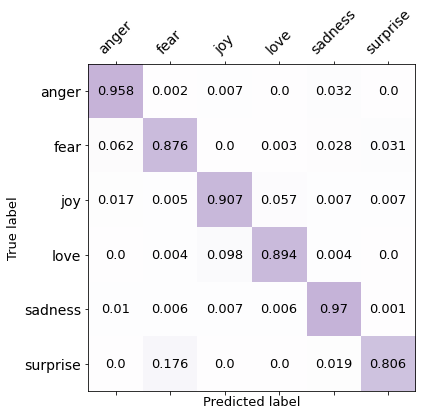

In [11]:
utils.model_evaluate(best_model, sequence_test, target_test, 32)

In [ ]:
# best_model.save('best_gru.h5')
# utils.dump(tokenizer,'/content/drive/MyDrive/__ed__/gru_B32/tokenizer.pickle')

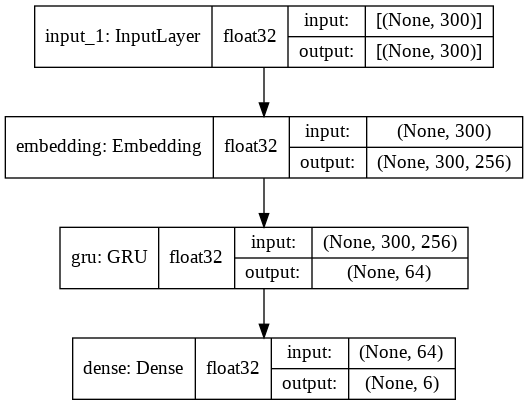

In [ ]:
from keras.utils import plot_model
plot_model(
    best_model,
    to_file='/content/drive/MyDrive/__ed__/gru_B32/plot.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True
    )